In [1]:
import torch
# Is CUDA available now?
print('CUDA available: {}'.format(torch.cuda.is_available()))

CUDA available: True


In [1]:
!conda env list

# conda environments:
#
base                     /home/theekshana/anaconda3
YOLO3D                *  /home/theekshana/anaconda3/envs/YOLO3D
sr                       /home/theekshana/anaconda3/envs/sr
stereo_rcnn              /home/theekshana/anaconda3/envs/stereo_rcnn



In [3]:
!chmod 777 -R /home/theekshana/Documents/visualDet3D

In [4]:
torch.version.cuda

'11.6'

In [2]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm

In [3]:
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

In [4]:
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

CUDA available: True


In [5]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn


In [5]:
print(dataset[0])

{'calib': [array([[ 7.40473449e+02,  0.00000000e+00,  6.32637975e+02,
         4.79214301e+01],
       [ 0.00000000e+00,  7.40473449e+02,  8.43123665e+01,
        -8.83392663e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         4.98101600e-03]]), array([[ 7.40473449e+02,  0.00000000e+00,  6.32637975e+02,
        -3.49902301e+02],
       [ 0.00000000e+00,  7.40473449e+02,  8.43123665e+01,
         2.10558863e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         3.20115300e-03]])], 'image': [array([[[-1.7240347 , -1.7030813 , -1.4384314 ],
        [-1.7240347 , -1.7193973 , -1.4384314 ],
        [-1.7240347 , -1.7205882 , -1.4538845 ],
        ...,
        [-1.2594154 , -0.982993  , -0.655263  ],
        [-1.2267191 , -0.9502801 , -0.67154676],
        [-1.1940229 , -0.9502801 , -0.67154676]],

       [[-1.7559652 , -1.7357244 , -1.4546804 ],
        [-1.681569  , -1.7520405 , -1.4546804 ],
        [-1.6619836 , -1.7532314 , -1.4701337 ],
        

In [6]:

# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

In [7]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [8]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [21]:
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
#     print(name)
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    return np.clip(rgb_image, 0, 255)

000075


/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.018437623977661133 seconds at call time 6
PSM Cos Volume takes 0.009200096130371094 seconds at call time 7
Cost Volume takes 0.0074634552001953125 seconds at call time 3


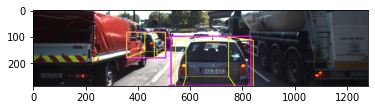

In [18]:
index = 75
a = compute_once(index)

In [12]:
from sort import *

ModuleNotFoundError: No module named 'filterpy'

In [19]:
pwd

'/home/theekshana/Documents/visualDet3D'

In [36]:
# cd /home/theekshana/Documents/visualDet3D

/home/theekshana/Documents/visualDet3D


In [10]:
#change  length 10 image names to 6 copied from seqential image list
# for i in range(2,78):
#     img = cv2.imread("/home/theekshana/Documents/visualDet3D/data/kitti_obj/training/image_3/"+"%010d" % i+".png")
#     img2 = img[:,:,::-1]
#     plt.imshow(img2)
#     print(i)
#     plt.show()
#     cv2.imwrite("/home/theekshana/Documents/visualDet3D/data/kitti_obj/training/image_3/"+"%06d" % i+".png",img)

000002


/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


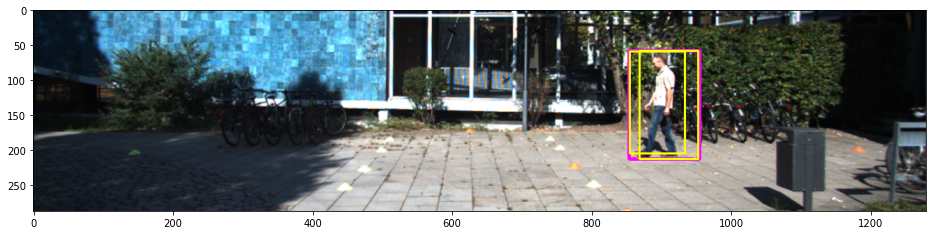

In [23]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
index += 1
a = compute_once(index, is_test_train=False, is_draw=True)

000000


/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.023612499237060547 seconds at call time 8
PSM Cos Volume takes 0.009454011917114258 seconds at call time 9
Cost Volume takes 0.007432460784912109 seconds at call time 4
0


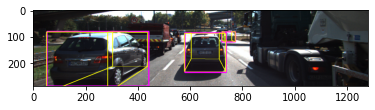

000001
PSM Cos Volume takes 0.023023128509521484 seconds at call time 10
PSM Cos Volume takes 0.00917673110961914 seconds at call time 11
Cost Volume takes 0.007645130157470703 seconds at call time 5
1


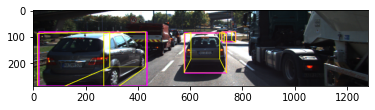

000002
PSM Cos Volume takes 0.023116111755371094 seconds at call time 12
PSM Cos Volume takes 0.013208866119384766 seconds at call time 13
Cost Volume takes 0.008244037628173828 seconds at call time 6
2


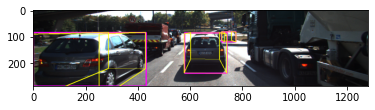

000003
PSM Cos Volume takes 0.01827406883239746 seconds at call time 14
PSM Cos Volume takes 0.009190559387207031 seconds at call time 15
Cost Volume takes 0.007582902908325195 seconds at call time 7
3


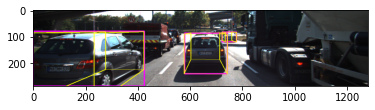

000004
PSM Cos Volume takes 0.02205181121826172 seconds at call time 16
PSM Cos Volume takes 0.010167837142944336 seconds at call time 17
Cost Volume takes 0.00767970085144043 seconds at call time 8
4


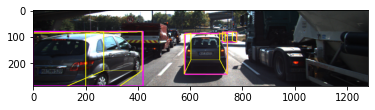

000005
PSM Cos Volume takes 0.022902488708496094 seconds at call time 18
PSM Cos Volume takes 0.013364315032958984 seconds at call time 19
Cost Volume takes 0.011861562728881836 seconds at call time 9
5


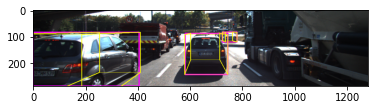

000006
6


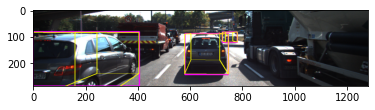

000007
7


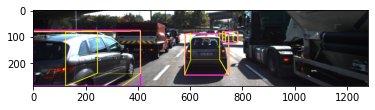

000008
8


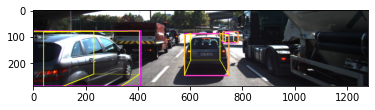

000009
9


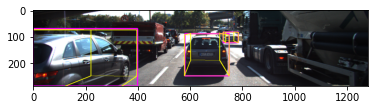

000010
10


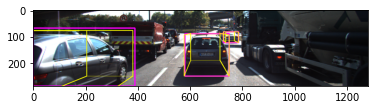

000011
11


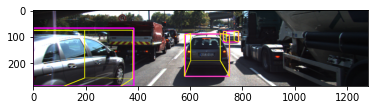

000012
12


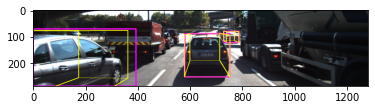

000013
13


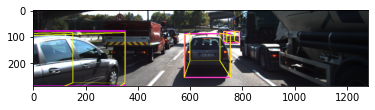

000014
14


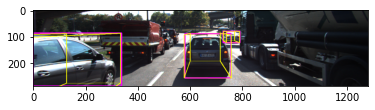

000015
15


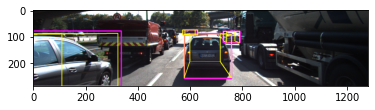

000016
16


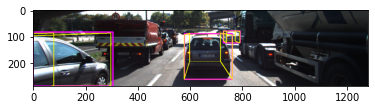

000017
17


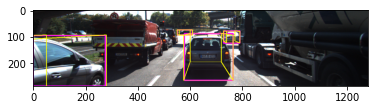

000018
18


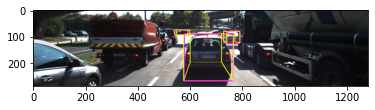

000019
19


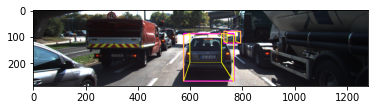

000020
20


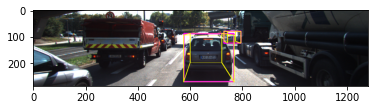

000021
21


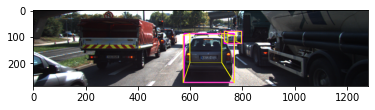

000022
22


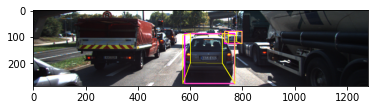

000023
23


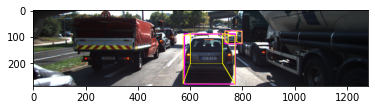

000024
24


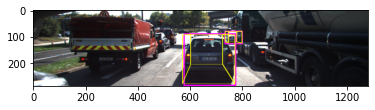

000025
25


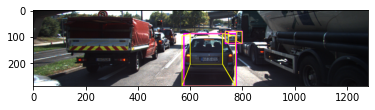

000026
26


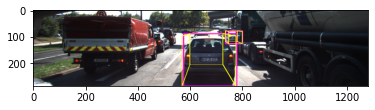

000027
27


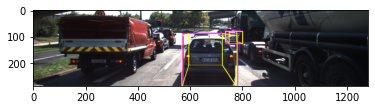

000028
28


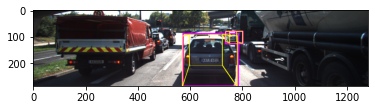

000029
29


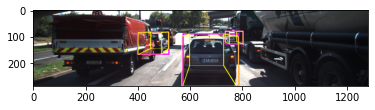

000030
30


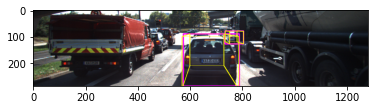

000031
31


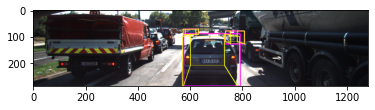

000032
32


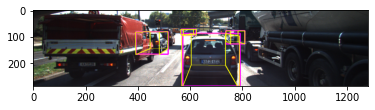

000033
33


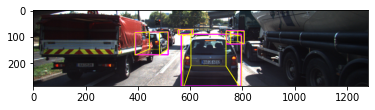

000034
34


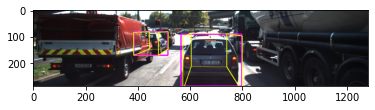

000035
35


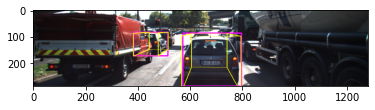

000036
36


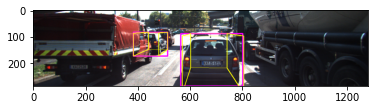

000037
37


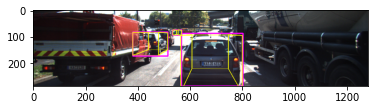

000038
38


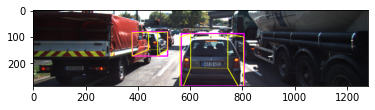

000039
39


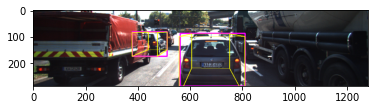

000040
40


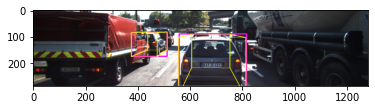

000041
41


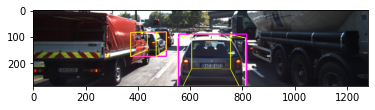

000042
42


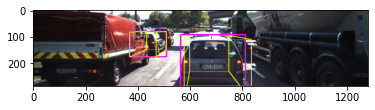

000043
43


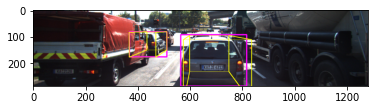

000044
44


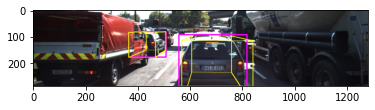

000045
45


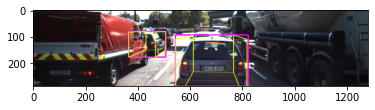

000046
46


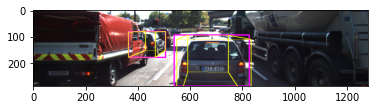

000047
47


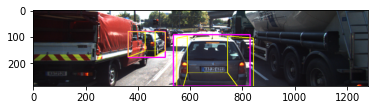

000048
48


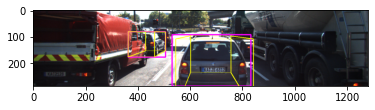

000049
49


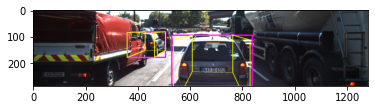

000050
50


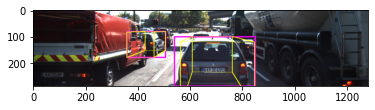

000051
51


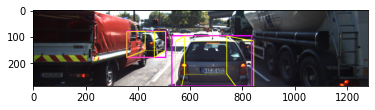

000052
52


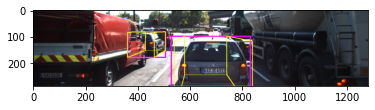

000053
53


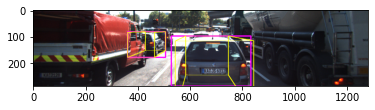

000054
54


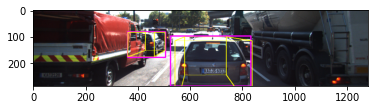

000055
55


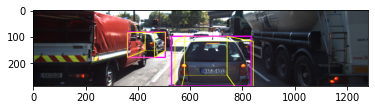

000056
56


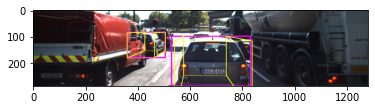

000057
57


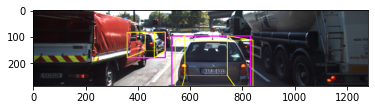

000058
58


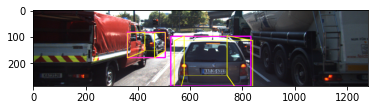

000059
59


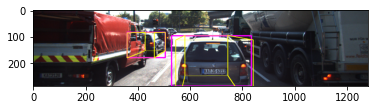

000060
60


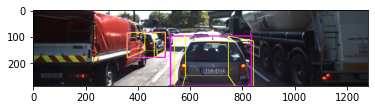

000061
61


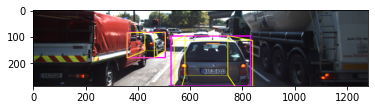

000062
62


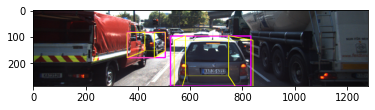

000063
63


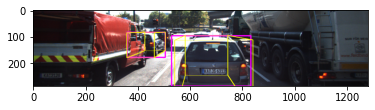

000064
64


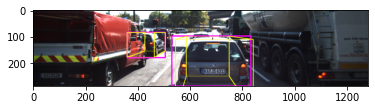

000065
65


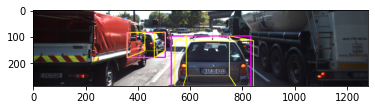

000066
66


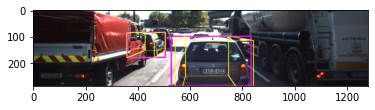

000067
67


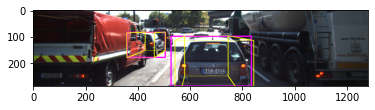

000068
68


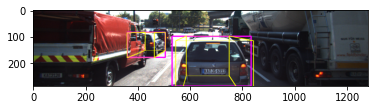

000069
69


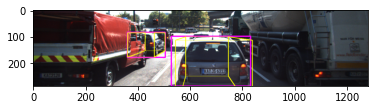

000070
70


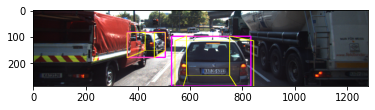

000071
71


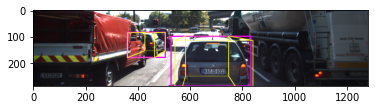

000072
72


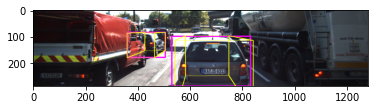

000073
73


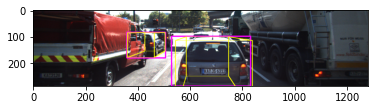

000074
74


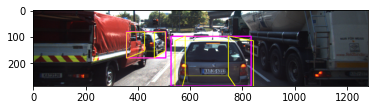

000075
75


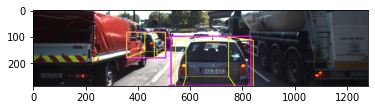

000076
76


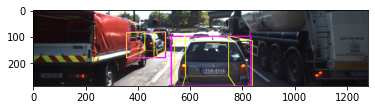

In [19]:
for index in range(0,77):
    a = compute_once(index, is_test_train=False, is_draw=True)
    print(index)
    plt.show()

In [ ]:
from IPython.display import clear_output

In [52]:
for index in range(0,77):
    a = compute_once(index, is_test_train=False, is_draw=True)
    clear_output(wait=True)
    plt.imshow(a, extent=[-100, 100, -1, 1], aspect=100)
    plt.xlabel(index)
    plt.show()

 

OutOfMemoryError: CUDA out of memory. Tried to allocate 46.00 MiB (GPU 0; 1.96 GiB total capacity; 1.10 GiB already allocated; 10.75 MiB free; 1.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#     print(index)      


# plt.text(0,3050,index,fontsize=12)
# ax.text(1, 13, 'Practice on GFG', style='italic', bbox={
#         'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

# # Adding title
# ax.set_title('Day v/s No of Questions on GFG', fontsize=15)
 
# # Adding axis title
# ax.set_xlabel('Day', fontsize=12)
# ax.set_ylabel('No of Questions', fontsize=12)